In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np


from model_SARIMA import find_SARIMA, build_SARIMA
from SARIMA_order import optimal_orders
from model_naiv import build_naive_model
from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import residual_plot, acf_resid_plot, box_pierce_test, ljung_box_test, durbin_watson_test, breusch_godfrey_test, run_test
from time_series import seasonal_plot, seasonal_subseries_plot, acf_plot, lag_plot, decompose


warnings.filterwarnings("ignore")

Datensatz lesen

In [20]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [21]:
# Filtern nach Store
store_number = 1
store = df[df['store'] == store_number].copy()

# Datensatz nach Datum sortieren und als Index setzen
store.sort_values('date', inplace=True)
store.set_index('date', inplace=True)

# Nur die Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

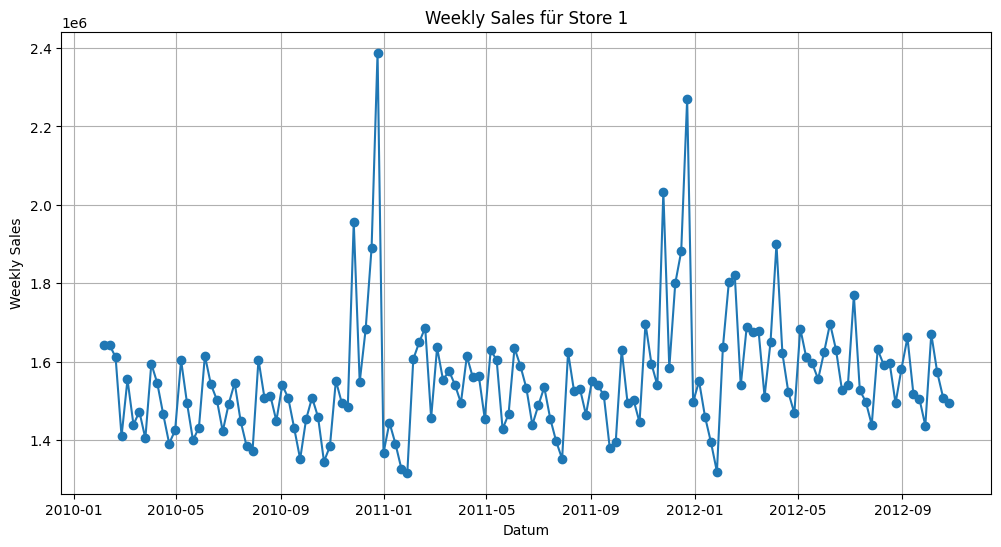

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store 1')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Seasonal

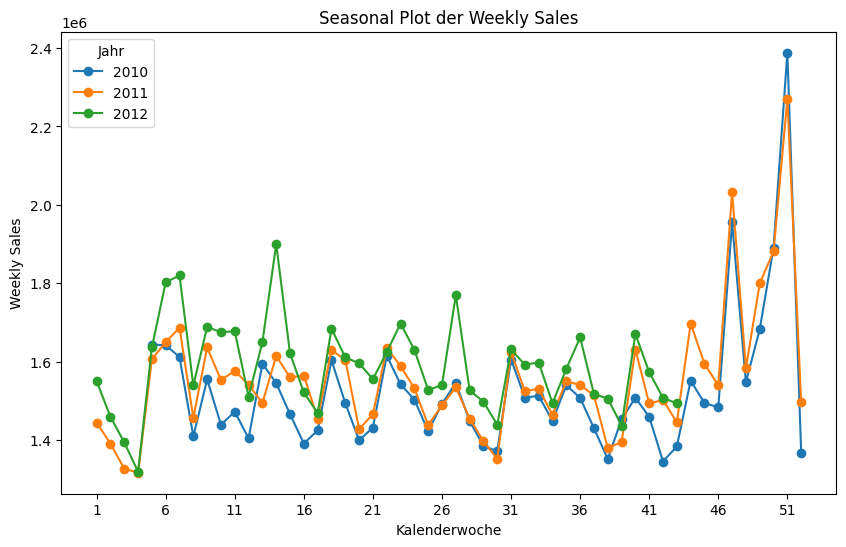

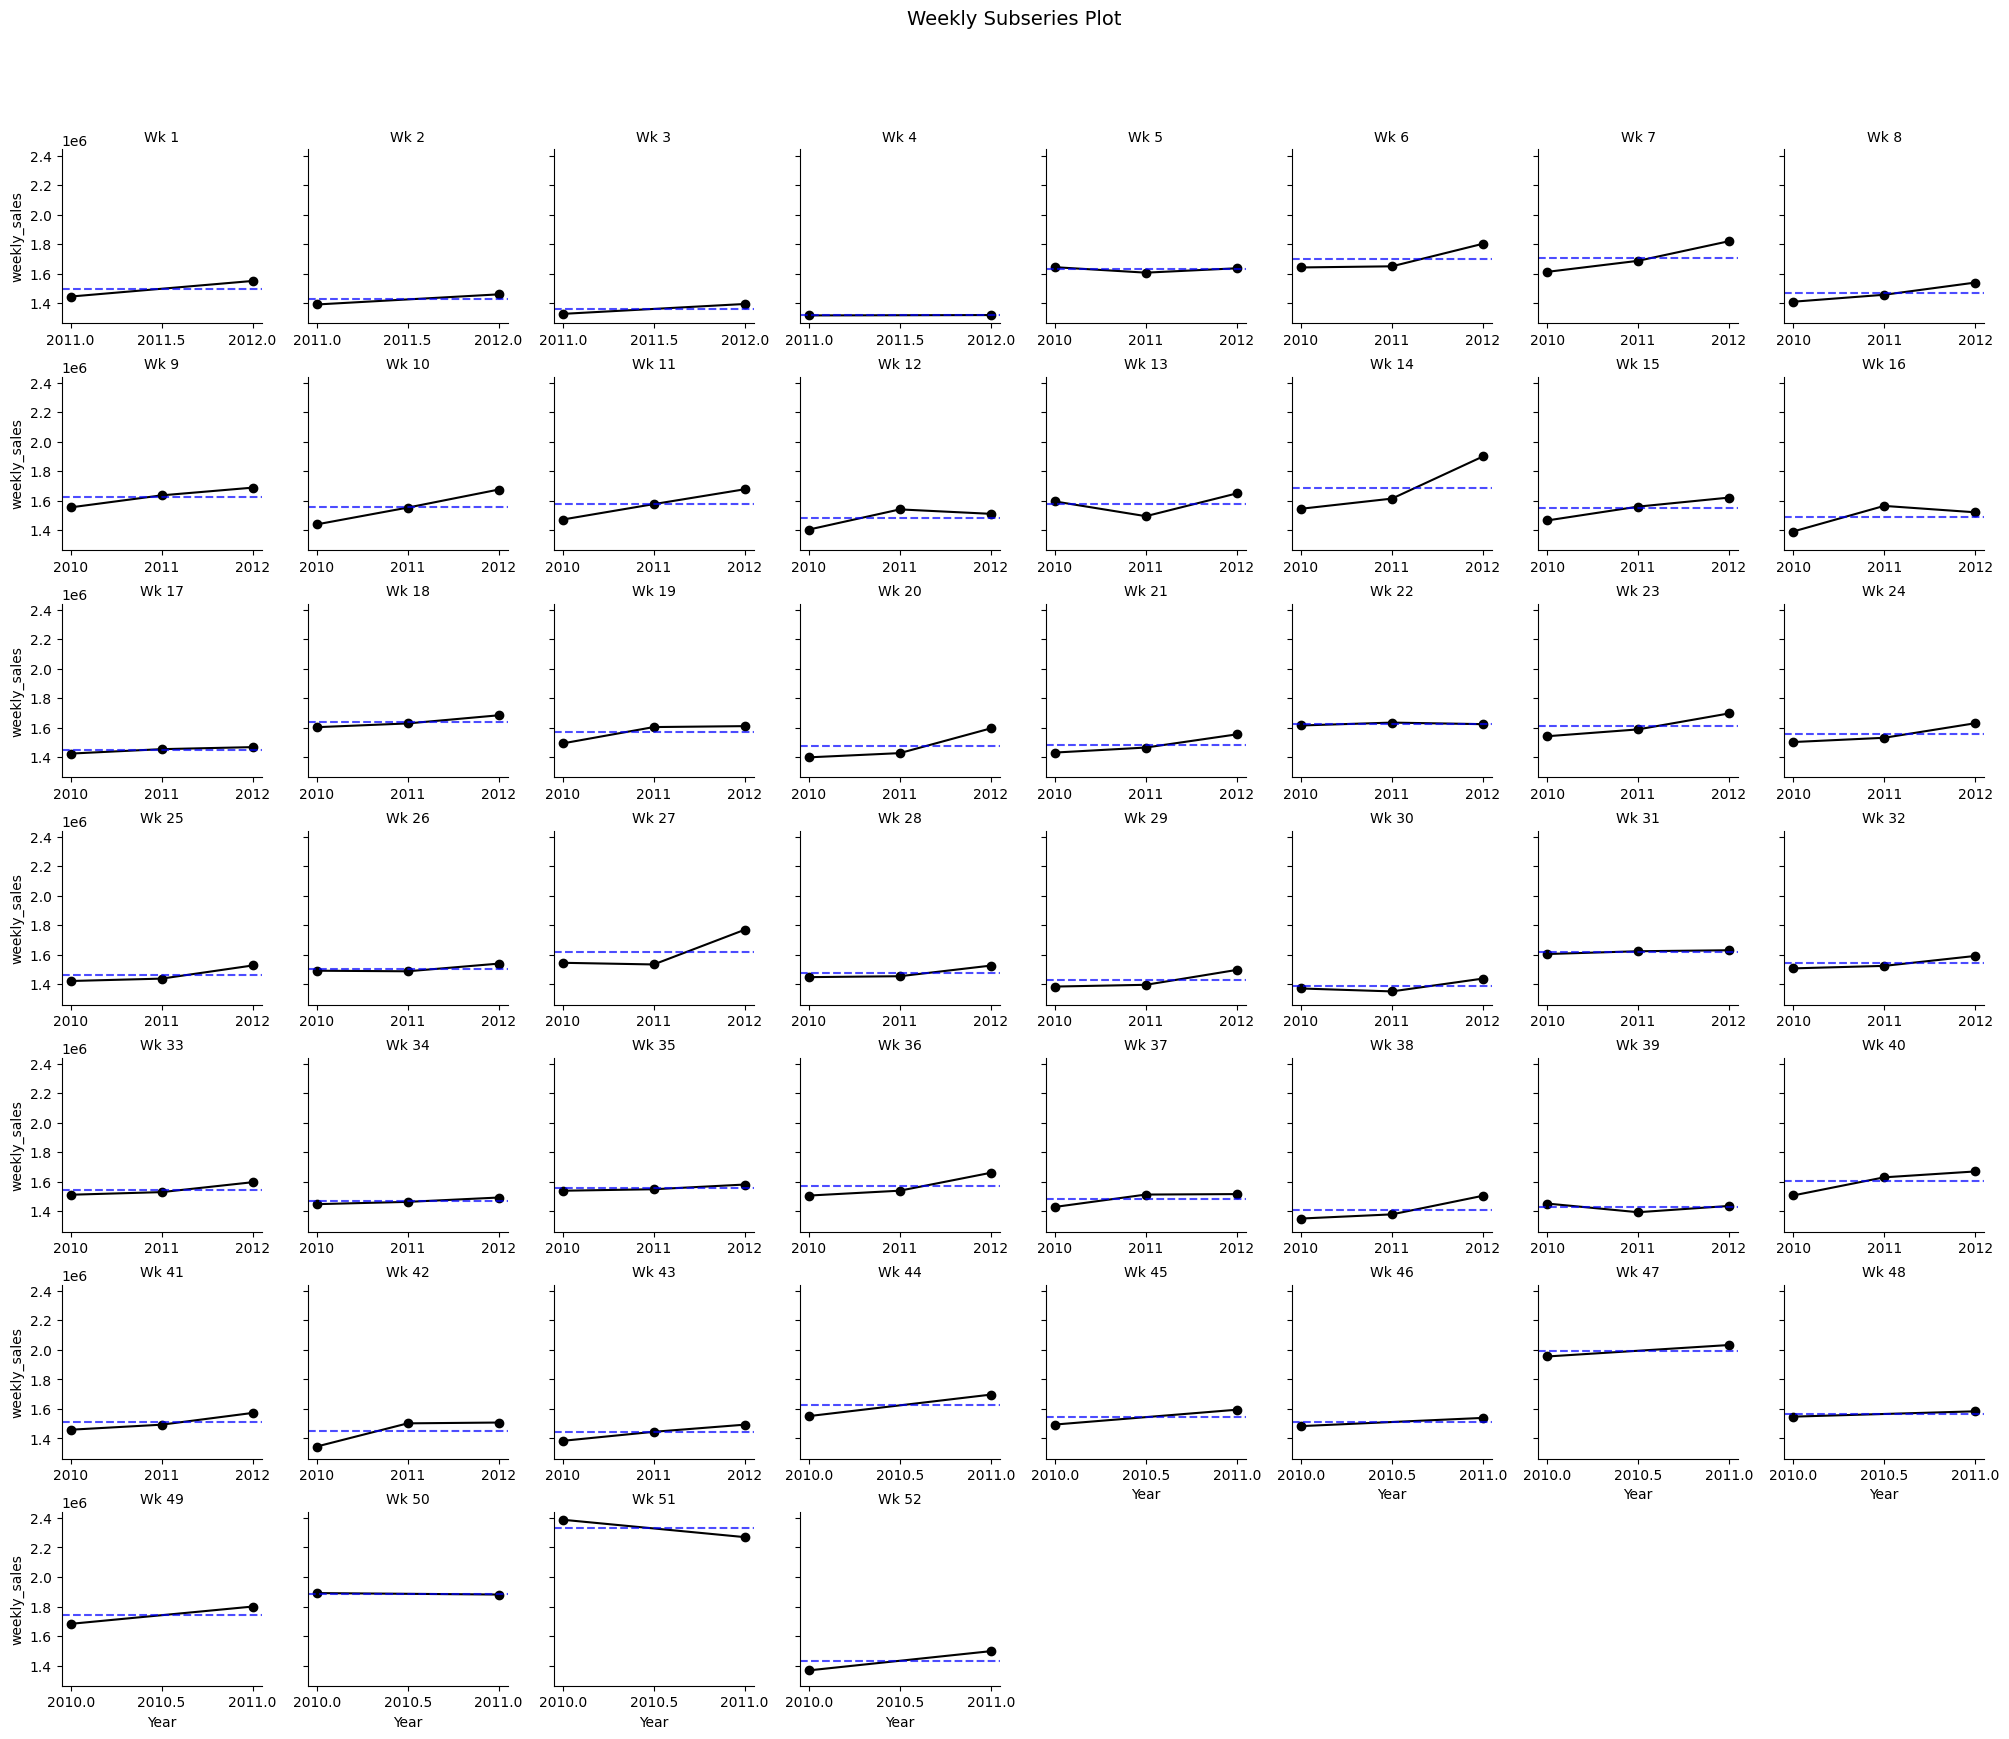

<Figure size 1200x600 with 0 Axes>

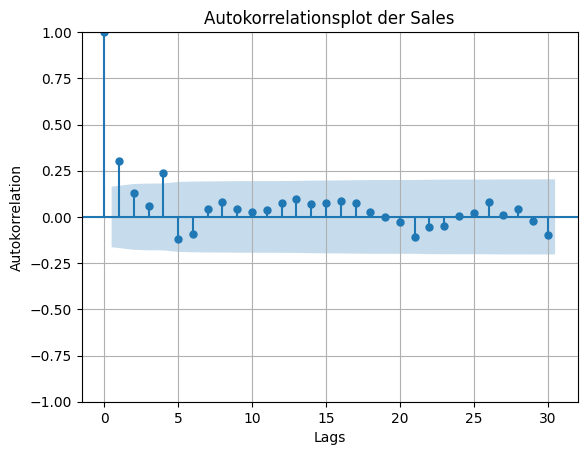

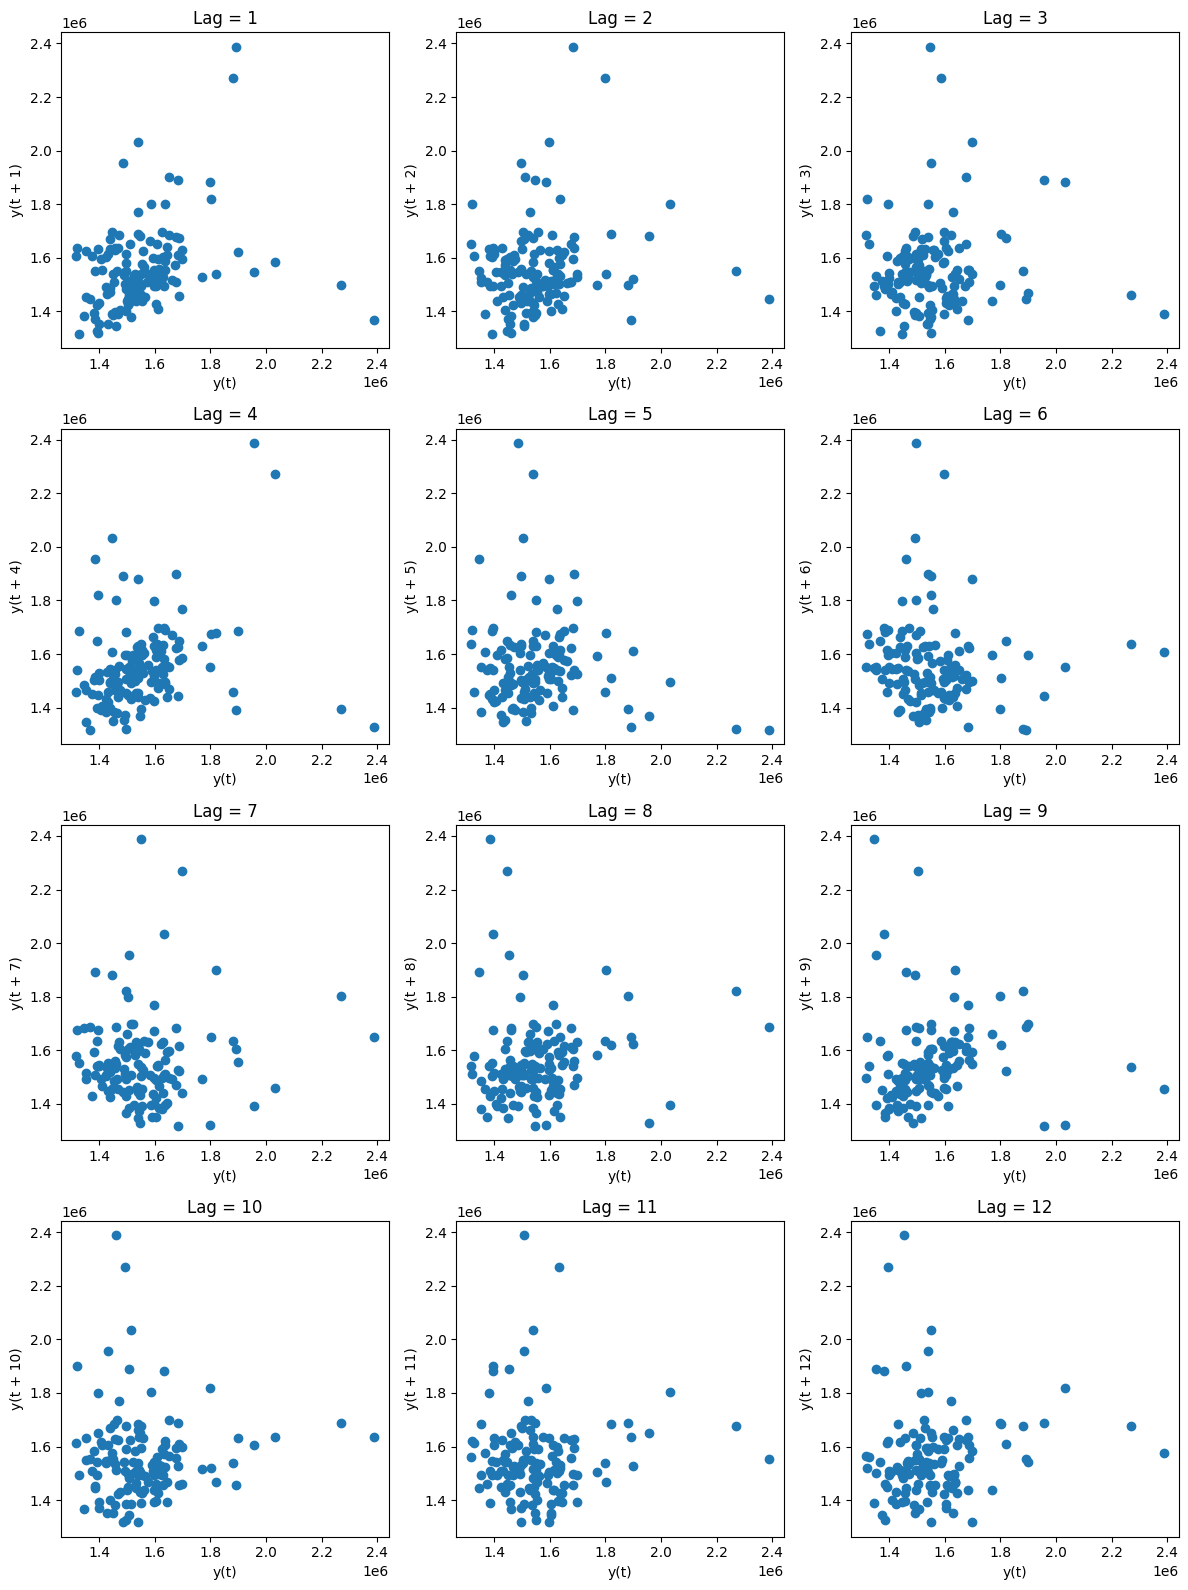

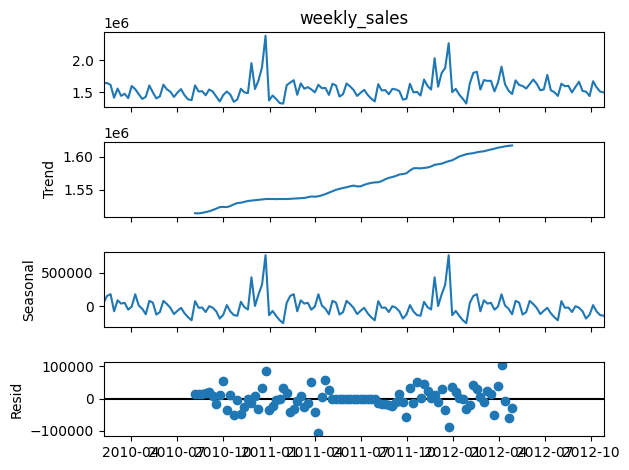

In [23]:
seasonal_plot(sales)
seasonal_subseries_plot(sales)
acf_plot(sales)
lag_plot(sales)
decompose(sales)

SARIMA Modell

In [24]:
sarima_params  = optimal_orders.get(str(store_number))
order = tuple(sarima_params["order"])
seasonal_order = tuple(sarima_params["seasonal_order"])

sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
sarima_fitted = sarima_model.fittedvalues
sarima_resid = sarima_model.resid

sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        weekly_sales   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 52)   Log Likelihood               -1884.296
Date:                             Sat, 08 Mar 2025   AIC                           3776.592
Time:                                     15:04:35   BIC                           3788.415
Sample:                                 02-05-2010   HQIC                          3781.396
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4168      0.091      4.596      0.000       0.239       0.594
ma.L1         -0.8985      0.048    -18.584      0.000      -0.993      -0.804
ar.S.L52       0.4936      0.038     12.973      0.000       0.419       0.568
sigma2      2.445e+10   3.87e-13   6.32e+22      0.000    2.44e+10    2.44e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.44   Jarque-Bera (JB):               155.95
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.48e+41. Standard errors may be unstable.
"""

Naives Modell

In [25]:
naiv_resid, naiv_fitted = build_naive_model(sales)

Modell wählen

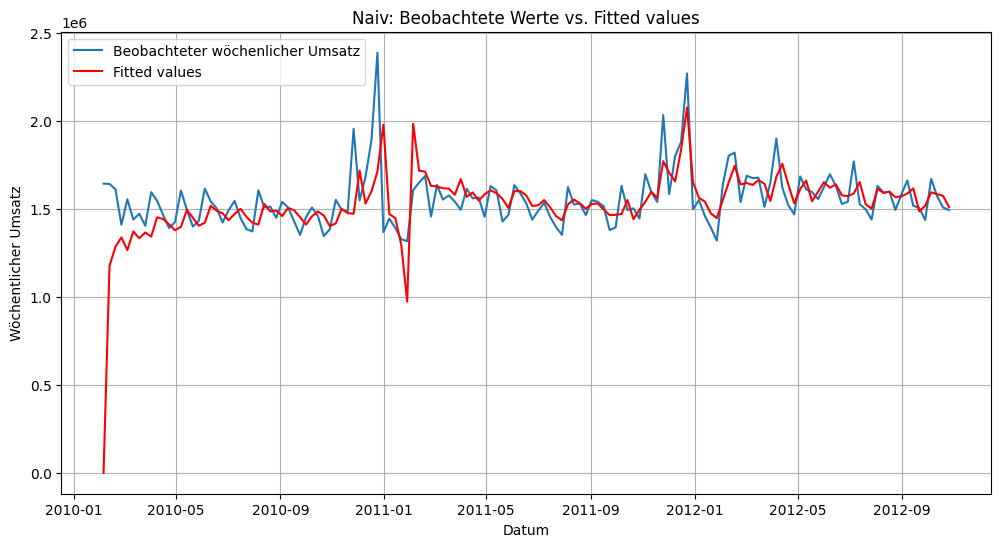

In [26]:
#residuen = naiv_resid
#fitted_values = naiv_fitted
residuen = sarima_resid
fitted_values = sarima_fitted


plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted values')
plt.title('Naiv: Beobachtete Werte vs. Fitted values')
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()

Korrelation Tests

Mittelwert der Residuen: 26122.4148


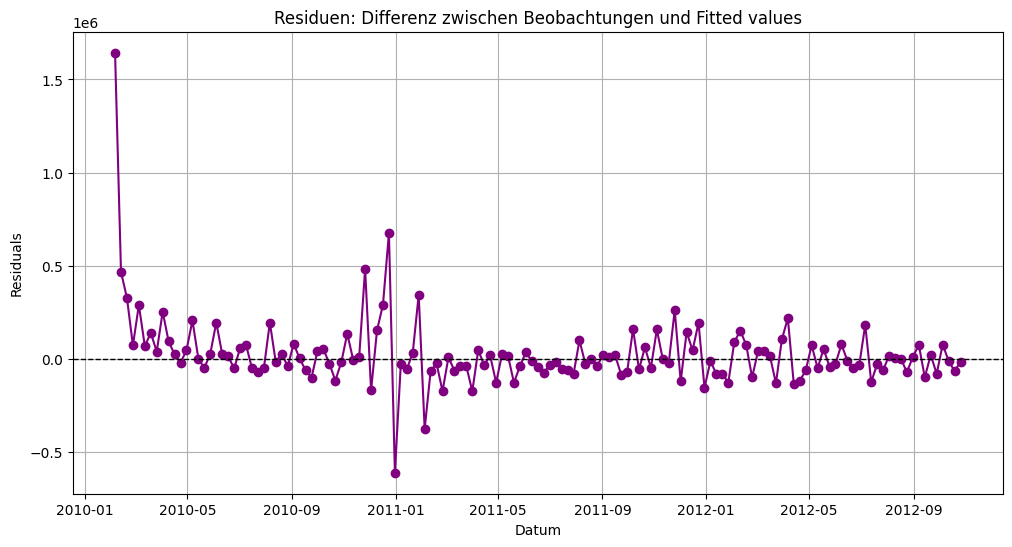

<Figure size 1200x600 with 0 Axes>

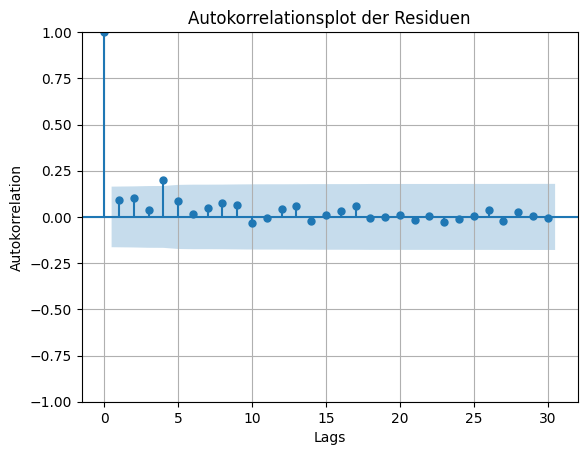

Box Pierce: 0.3150
Ljung Box: 0.2791
Breusch Godfrey: 0.9771
Run Test: 0.1146


In [27]:
mean_resid = residuen.mean()
print(f"Mittelwert der Residuen: {mean_resid:.4f}")


residual_plot(residuen)
acf_resid_plot(residuen)


bp_stat, bp_pvalue = box_pierce_test(residuen)
print(f"Box Pierce: {bp_pvalue:.4f}")

lb_stat, lb_pvalue = ljung_box_test(residuen)
print(f"Ljung Box: {lb_pvalue:.4f}")

bg_stat, bg_pvalue = breusch_godfrey_test(residuen)
print(f"Breusch Godfrey: {bg_pvalue:.4f}")

rt_stat, rt_pvalue = run_test(residuen)
print(f"Run Test: {rt_pvalue:.4f}")

Mittelwert Tests

In [29]:
t_stat, t_pvalue = t_test(residuen)
print(f"T-Test: {t_pvalue:.4f}")

w_stat, w_pvalue = wilcoxon_test(residuen)
print(f"Wilcoxon Test: {w_pvalue:.4f}")

n_total, n_pos, b_pvalue = binomial_test(residuen)
print(f"Binomial Test: {b_pvalue:.4f}")

k_stat, k_pvalue = kolmogorov_test(residuen)
print(f"Kolmogorov Test: {k_pvalue:.4f}")

T-Test: 0.1142
Wilcoxon Test: 0.7671
Binomial Test: 0.6160
Kolmogorov Test: 0.0000
